In [ ]:
import os
# Set working directory manually on Gadi to be able to load csv files
user = os.getenv('USER')
os.chdir('/scratch/cd82/'+user+'/notebooks/')

# 🌳 Decision Tree Classification with Heart Disease Dataset

## What is a Decision Tree?

A **Decision Tree** is a supervised machine learning model that splits the data into branches to make predictions. It works by asking a series of yes/no questions (based on features) to divide the data until a decision is made.

### Key Concepts:
- **Gini Impurity** or **Entropy** is used to determine the best feature and threshold to split at each node.
- Decision Trees are **interpretable**, but they can **overfit** the training data.

## Common Hyperparameters
- `max_depth`: Limits how deep the tree can go (helps prevent overfitting).
- `min_samples_split`: Minimum number of samples required to split an internal node.
- `min_samples_leaf`: Minimum number of samples that a leaf node must have.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import shap

# Load the dataset
df = pd.read_csv("heart.csv")
X = df.drop("target", axis=1)
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 🌲 Hyperparameter 1: `max_depth`

`max_depth` controls how deep the decision tree can grow. A shallow tree (e.g., `max_depth=2`) may **underfit** the data, while a very deep tree (e.g., `None` = no limit) may **overfit** the training set.

Below, we train several models with different `max_depth` values and observe the training and test accuracy.


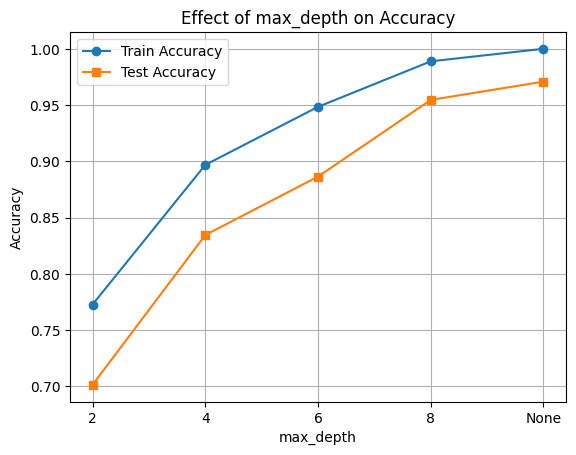

In [2]:
depths = [2, 4, 6, 8, None]
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

depth_labels = [str(d) if d is not None else "None" for d in depths]
plt.plot(depth_labels, train_scores, marker='o', label='Train Accuracy')
plt.plot(depth_labels, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Effect of max_depth on Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## ✂️ Hyperparameter 2: `min_samples_split`

This parameter defines the **minimum number of samples required to split an internal node**.

- Higher values prevent the tree from splitting too soon, which can reduce overfitting.
- Lower values allow the tree to grow deeper, which can increase accuracy but also risk overfitting.

Let's observe how changing `min_samples_split` impacts model performance.


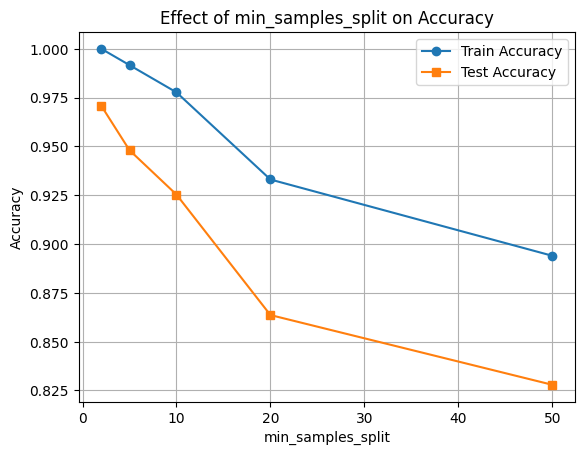

In [3]:
min_samples = [2, 5, 10, 20, 50]
train_scores, test_scores = [], []

for min_split in min_samples:
    clf = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.plot(min_samples, train_scores, marker='o', label='Train Accuracy')
plt.plot(min_samples, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Effect of min_samples_split on Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## 🍃 Hyperparameter 3: `min_samples_leaf`

This parameter controls the **minimum number of samples required to be at a leaf node**.

- It prevents the model from learning from very small subsets of data.
- Larger values make the model more conservative and help reduce overfitting.

We'll now test how different values for `min_samples_leaf` affect the performance of our Decision Tree.


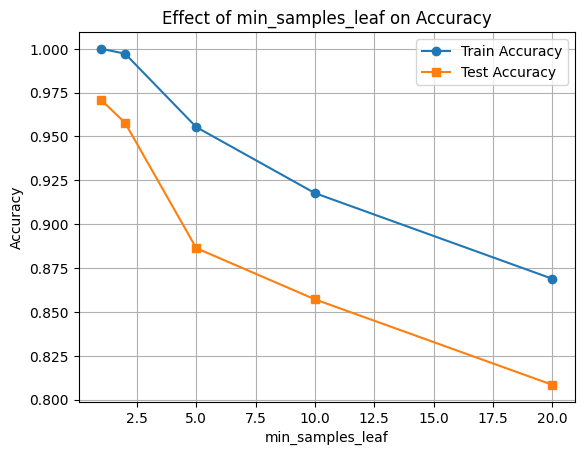

In [4]:
min_leaves = [1, 2, 5, 10, 20]
train_scores, test_scores = [], []

for min_leaf in min_leaves:
    clf = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.plot(min_leaves, train_scores, marker='o', label='Train Accuracy')
plt.plot(min_leaves, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Effect of min_samples_leaf on Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## ✅ Final Model with Selected Hyperparameters

We'll now train a final Decision Tree model using the best combination of parameters observed in our experiments. Then we'll use SHAP to interpret feature importance.


In [5]:
# Final model (tuned)
final_clf = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, random_state=42)
final_clf.fit(X_train, y_train)

# Accuracy
train_acc = final_clf.score(X_train, y_train)
test_acc = final_clf.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


Train Accuracy: 0.937
Test Accuracy: 0.873


              precision    recall  f1-score   support

           0       0.92      0.82      0.87       159
           1       0.83      0.93      0.88       149

    accuracy                           0.87       308
   macro avg       0.88      0.88      0.87       308
weighted avg       0.88      0.87      0.87       308



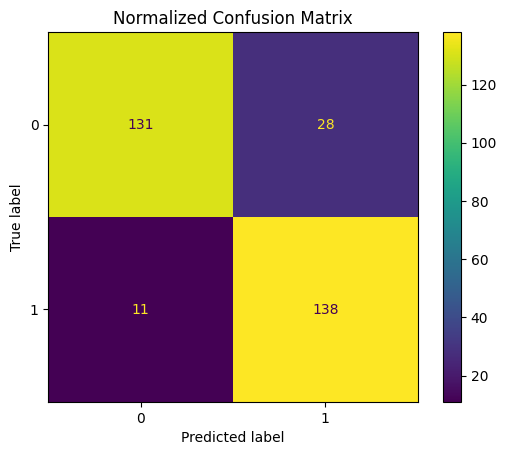

In [6]:

y_pred = final_clf.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(final_clf, X_test, y_test)
plt.title("Normalized Confusion Matrix")
plt.show()


## 🧠 Feature Importance with SHAP

We'll use SHAP (SHapley Additive exPlanations) to understand how different features contribute to the model's predictions.

This helps us:
- Identify the most influential features
- Understand direction and magnitude of impact


### 📊 Interpreting the SHAP Summary Plot

The SHAP summary plot visualizes how each feature contributes to the model's output across all samples. Here's what each component means:

| Element                      | Description                                                                                      |
|-----------------------------|--------------------------------------------------------------------------------------------------|
| **Y-axis (Feature Names)**  | Features are sorted by overall importance (top = most important).                              |
| **X-axis (SHAP value)**     | The impact of that feature on the model's prediction.                                           |
| **Each Dot**                | A single row/sample in the dataset.                                                             |
| **Color (Dot Hue)**         | The feature value for that sample — red = high, blue = low.                                    |
| **Direction of SHAP Value**| Positive SHAP value pushes the prediction toward the positive class (e.g., "disease" class).    |
|                             | Negative SHAP value pushes it toward the negative class (e.g., "no disease").                   |

**🧠 Example Interpretation:**  
If the “Age” feature has mostly red dots (high values) with positive SHAP values, it means higher ages are pushing predictions toward the positive class.


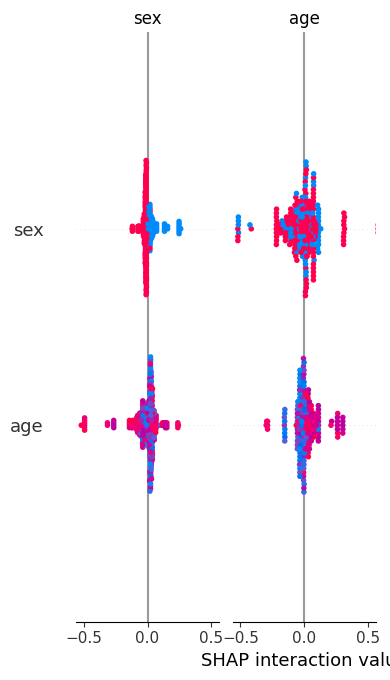

In [7]:
import shap

explainer = shap.Explainer(final_clf, X_train, feature_names=X.columns)
shap_values = explainer(X_test)

# Plot summary for both classes
shap.summary_plot(shap_values, X_test)
